## install and import module

In [22]:
%%capture
!pip install timm

In [23]:
import os
import random
import numpy as np
import torch
import cv2
import timm
import copy
import albumentations as A
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.optim import AdamW
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold

In [24]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/programmers_deep_learning')
current_dir = os.getcwd()

In [25]:
#### Set Device, Fix seed
import os
import random
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 4064

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

## make dataset and dataloader  
* if you want mix-up or cut-mix, read this doc https://timm.fast.ai/mixup_cutmix

In [26]:
train_files_dir = os.path.join(current_dir, 'data/train')
class_list = os.listdir(train_files_dir)

In [27]:
def get_np_img(dataset_dir):
  ## 데이터셋이 폴더로 있는 dir를 지정하면
  ## 해당 위치의 data와 label을 리턴함.
  file_list = []
  label_list = []
  class_list = os.listdir(dataset_dir)
  mapping_dict = {class_name:idx for idx, class_name in enumerate(class_list)}
  for class_name in class_list:
    class_dir = os.path.join(dataset_dir, class_name)
    file_names = os.listdir(class_dir)
    class_files = [os.path.join(class_dir, file_name) for file_name in file_names]
    labels = [mapping_dict[class_name]]*len(file_names)
    file_list.extend(class_files)
    label_list.extend(labels)
  np_files = np.array(file_list)
  np_labels = np.array(label_list)
  return np_files, np_labels

In [28]:
class CustomTrainDataset(Dataset):
  ## albumentation 사용을 위해 cv2.imread를 사용함.
  def __init__(self, files, labels, transforms=None):
    self.files = files
    self.labels = labels
    self.transform = transforms

  def __getitem__(self, index):
    img = cv2.imread(files[index], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.transform(image=img)["image"]
    label = labels[index]
    return img, torch.tensor(label, dtype=torch.int64) # transform에서 tensor로 변환됨.

  def __len__(self):
    return len(self.labels)

In [29]:
class CustomValidDataset(Dataset):
  ## albumentation 사용을 위해 cv2.imread를 사용함.
  def __init__(self, files, labels, transforms=None):
    self.files = files
    self.labels = labels
    self.transform = transforms

  def __getitem__(self, index):
    img = cv2.imread(files[index], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.transform(image=img)["image"]
    label = labels[index]
    return img, torch.tensor(label, dtype=torch.int64) # transform에서 tensor로 변환됨.

  def __len__(self):
    return len(self.labels)

## select timm pre-train model  
  * https://timm.fast.ai/  

In [30]:
## timm pre-train 지원 모델 확인
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1

In [31]:
model_name = "vit_base_patch16_224"
model = timm.create_model(model_name=model_name,
                          pretrained=True,
                          num_classes=10).to(device) # input your dataset class nums

## loss func, scheduler, optimizer  
* scheduler summery doc : https://gaussian37.github.io/dl-pytorch-lr_scheduler/

In [32]:
optim = AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingWarmRestarts(optim, T_0=5, T_mult=2, eta_min=1e-4)

## data split for validation and k-fold

In [33]:
files, labels = get_np_img(train_files_dir)

In [34]:
train_files, valid_files, train_labels, valid_labels = train_test_split(files,
                                                                        labels,
                                                                        train_size=0.8,
                                                                        shuffle=True,
                                                                        random_state=random_seed,
                                                                        stratify=labels)

train_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.Rotate(),
                              A.HorizontalFlip(),
                              A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                              A.Normalize(),
                              ToTensorV2()
                              ])

valid_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.Normalize(),
                              ToTensorV2()
                              ])

train_dataset = CustomTrainDataset(train_files, train_labels, transforms=train_transforms)
valid_dataset = CustomValidDataset(valid_files, valid_labels, transforms=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [35]:
train_files[0], valid_files[0]

('/content/drive/MyDrive/Colab Notebooks/programmers_deep_learning/data/train/person/pic_071.jpg',
 '/content/drive/MyDrive/Colab Notebooks/programmers_deep_learning/data/train/giraffe/pic_150.jpg')

In [36]:
train_dataset[1][0][0]

tensor([[ 1.1187,  1.1015,  1.1015,  ..., -0.9705, -0.9877, -0.9877],
        [ 1.1015,  1.1015,  1.1015,  ..., -0.9534, -0.9705, -0.9877],
        [ 1.1187,  1.1015,  1.1015,  ..., -0.9534, -0.9705, -0.9705],
        ...,
        [ 0.8961,  0.8789,  0.8789,  ..., -1.2788, -1.3130, -1.3473],
        [ 0.9132,  0.8789,  0.8789,  ..., -1.2959, -1.3130, -1.3644],
        [ 0.8961,  0.8789,  0.8789,  ..., -1.2959, -1.3130, -1.3644]])

In [37]:
valid_dataset[1][0][0]

tensor([[-0.9877, -0.9363, -0.9192,  ...,  1.8037,  1.7694,  1.9749],
        [-0.9877, -0.9363, -0.9192,  ...,  1.8208,  1.7865,  1.9920],
        [-1.0219, -0.9705, -0.9192,  ...,  1.8379,  1.8037,  2.0092],
        ...,
        [-1.3644, -1.3815, -1.3815,  ...,  1.4954,  1.5982,  1.6838],
        [-1.3130, -1.3473, -1.3302,  ...,  1.4954,  1.5982,  1.6838],
        [-1.3130, -1.3302, -1.3302,  ...,  1.4954,  1.5982,  1.6838]])

## show argumentations

In [38]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    print(dataset[0][1])
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, label = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

tensor(0)


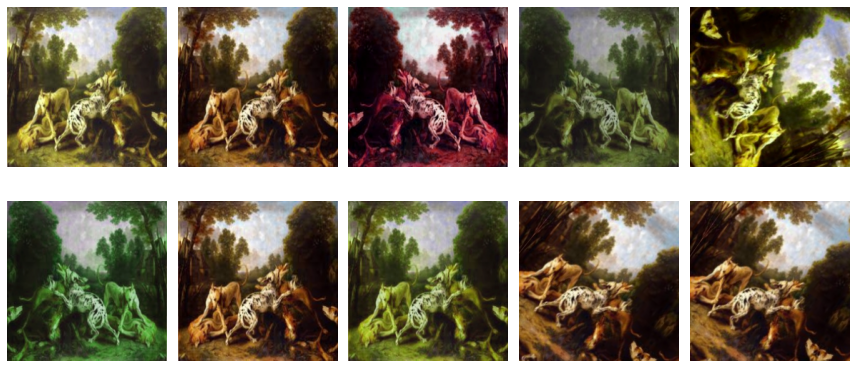

In [39]:
visualize_augmentations(train_dataset, idx=0)

tensor(0)


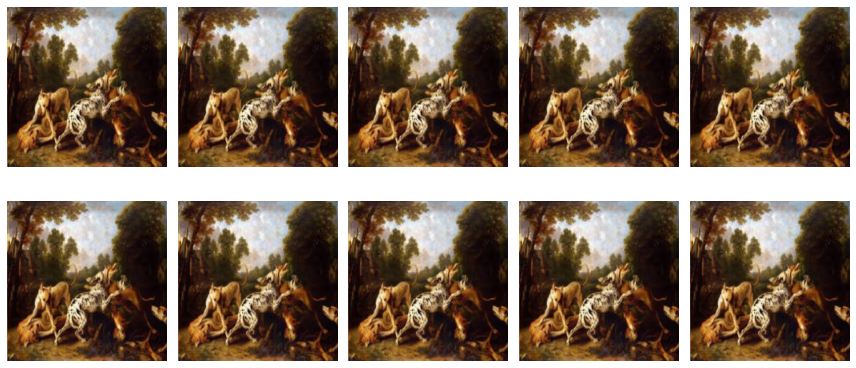

In [40]:
visualize_augmentations(valid_dataset, idx=0) # 왜 valid와 trainset의 img가 동일하지?

## train & validation

In [47]:
def train_and_valid(model, train_loader, valid_loader, epochs, optimizer, criterion):
  result = {"train_loss":[],
            "valid_loss":[],
            "train_acc":[],
            "valid_acc":[]}
  for epoch in tqdm(range(1, epochs+1)):
    model.train()
    epoch_train_loss = []
    epoch_valid_loss = []
    epoch_valid_acc = []
    epoch_valid_f1 = []

    for iter_idx, (train_imgs, train_labels) in enumerate(train_loader, start=1):
      train_imgs, train_labels = train_imgs.to(device, dtype=torch.float), train_labels.to(device)
      optimizer.zero_grad()
      train_pred = model(train_imgs)
      train_loss = criterion(train_pred, train_labels)
      train_loss.backward()
      optimizer.step()
      epoch_train_loss.append(train_loss.cpu().item())


    with torch.no_grad():
      for iter_idx, (valid_imgs, valid_labels) in enumerate(valid_loader, start=1):
        model.eval()
        valid_imgs, valid_labels = valid_imgs.to(device, dtype=torch.float), valid_labels.to(device)
        valid_pred = model(valid_imgs)
        valid_loss = criterion(valid_pred, valid_labels)
        epoch_valid_loss.append(valid_loss.cpu().item())
        valid_pred_c = valid_pred.argmax(dim=-1)

        epoch_valid_acc.extend(  (valid_pred_c==valid_labels).cpu().tolist()  )
        iter_f1_score = f1_score(y_true=valid_labels.cpu().numpy(), y_pred=valid_pred_c.cpu().numpy(), average="macro")
        epoch_valid_f1.append(iter_f1_score)


    train_loss = np.mean(epoch_train_loss)
    valid_loss = np.mean(epoch_valid_loss)
    valid_acc = np.mean(epoch_valid_acc)
    valid_f1 = np.mean(epoch_valid_f1)

    print(f"    {epoch}/{epochs} : train_loss:{train_loss:.4f}, valid_loss:{valid_loss:.4f}, valid_acc:{valid_acc:.2f}, valid_f1:{valid_f1:.2f}")

    result['train_loss'] = train_loss
    result['valid_loss'] = valid_loss
    result['valid_acc'] = valid_acc
    result['valid_f1'] = valid_f1

    ## input early stop code
  
  return result, model


In [48]:
train_and_valid(model, train_loader, valid_loader, 5, optim, criterion)

 20%|██        | 1/5 [01:26<05:46, 86.72s/it]

1/6 : train_loss:2.5350, valid_loss:1.1521, valid_acc:0.97, valid_f1:0.57


 20%|██        | 1/5 [02:21<09:25, 141.46s/it]


KeyboardInterrupt: ignored